**This notebook is focusing on the user_anime_full data**

# Analysis and Modeling for User_Anime_Full Data

Basic setup and import 

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import seaborn as sb
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = "/content/gdrive/Shareddrives/545 Project"
os.chdir(path)
os.listdir(path)

['Notebook',
 'spark-3.0.1-bin-hadoop3.2.tgz.1',
 'spark-3.0.1-bin-hadoop3.2.tgz.2',
 'AnimeList.csv',
 'spark-3.0.1-bin-hadoop3.2.tgz',
 'spark-3.0.1-bin-hadoop3.2',
 'UserList.csv',
 'spark-3.0.1-bin-hadoop3.2.tgz.3',
 'UserAnimeList.csv',
 'UserAnime_cleaned.csv',
 'user_list_filtered.csv',
 'User_Anime_Full.csv',
 'User_Anime_Fuill_r.csv',
 'User_Anime_Full_r.csv',
 'user_full.csv',
 'Anime_cleaned.csv',
 'user_anime_full_100k.csv']

Load Data

In [ ]:
# Load data
Full_data = pd.read_csv('User_Anime_Full_r.csv')

In [ ]:
# Full_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).to_csv('User_Anime_Fuill_r.csv')
# !cp User_Anime_Fuill_r.csv /content/gdrive/Shareddrives/545\ Project/

# Visualization


This Section is going to visualize and justify the availability of modeling on studio and rating of animes.

In [ ]:
# Create a dataframe only contains the information of studio, gender
gender_studio_df = Full_data.drop_duplicates(subset=['user_id'])[['studio', 'user_id', 'gender']]
gender_studio_df = gender_studio_df.groupby(by=['studio','gender']).count().reset_index().rename(columns={'user_id': 'count'})
gender_studio_df

,studio,gender,count
0,8bit,Female,95
1,8bit,Male,344
2,8bit,Non-Binary,5
3,A-1 Pictures,Female,1385
4,A-1 Pictures,Male,2754
...,...,...,...
453,feel.,Male,370
454,feel.,Non-Binary,3
455,ufotable,Female,219
456,ufotable,Male,637


In [ ]:
# Plot the figure using plotly
fig = px.bar(gender_studio_df, x="count", y="studio", color="gender", 
              orientation='h', title="studio-gender")
fig.update_layout(height=3000, xaxis_tickangle=0)
fig.update_yaxes(dtick=1, categoryorder="total ascending")
fig.show()

The figure above shows that the distribution of audience among studios are pretty imbalanced. The gender distribution is also imbalanced. There are too many studios, resampling may not be a good idea.

Thus it is not a good idea to build models on studios. 

Visualize the rating as well as the gender distribution within each rating.

In [ ]:
rating_gender_df = Full_data.drop_duplicates(subset=['user_id'])[['rating', 'user_id', 'gender']]
rating_gender_df = rating_gender_df.groupby(by=['rating','gender']).count().reset_index().rename(columns={'user_id': 'count'})
rating_gender_df[rating_gender_df['rating'] != 'None']

,rating,gender,count
0,G - All Ages,Female,1019
1,G - All Ages,Male,826
2,G - All Ages,Non-Binary,11
4,PG - Children,Female,1498
5,PG - Children,Male,1672
6,PG - Children,Non-Binary,21
7,PG-13 - Teens 13 or older,Female,24509
8,PG-13 - Teens 13 or older,Male,43520
9,PG-13 - Teens 13 or older,Non-Binary,319
10,R - 17+ (violence & profanity),Female,6288


In [ ]:
fig = px.bar(rating_gender_df[rating_gender_df['rating'] != 'None'], x="count", y="rating", color="gender", title="rating-gender", 
             orientation='h')
fig.update_layout(width=1200)
fig.update_yaxes(dtick=1, categoryorder="total ascending")
fig.show()

The figure above shows that PG-13 almost dominates the whole rating data. The imbalanced data may bring some diffuculties when modeling.

However, from visualizations above, the distribution of gender is somewhat imbalanced, but it can be fixed by resample techniques.

# Modeling: Predict score and members of a give anime

## Linear regression On Score

First we do some simple linear regression on the `Anime_cleaned.csv`, which contains cleaned data about over 8000 animes. Among the four criteria about quality. We take `score` as an example and do Linear Regression on it. 

In [ ]:
anime_df = pd.read_csv('Anime_cleaned.csv', header=[0])

Drop some useless coulumn, like `title`. `title_japanese` and `anime_id`. Also, `score`,`rank`,`scored_by`,`popularity`.`favorites` are all criteria to define the quality of an anime, so when doing Linear Regression on Score, we must drop these columns.

In [ ]:
anime_learning_df = anime_df.drop(columns=['Unnamed: 0','title','scored_by','rank','popularity','members','favorites','title_japanese','anime_id'])

Then we apply One-hot encoding for `type`,`source`,`rating`, `studio` and `genre`. Convert them to columns with 1 and 0 representing if current entry has such feature.

In [ ]:
anime_learning_df['rating'] = anime_learning_df['rating'].astype('category')
anime_learning_df['type'] = anime_learning_df['type'].astype('category')
anime_learning_df['source'] = anime_learning_df['source'].astype('category')
anime_learning_df['studio'] = anime_learning_df['studio'].astype('category')
anime_learning_df['genre'] = anime_learning_df['genre'].astype('category')

In [ ]:
one_hot1 = pd.get_dummies(anime_learning_df['rating'],prefix='rating')
anime_learning_df = pd.concat([anime_learning_df, one_hot1], axis= 1)

one_hot2 = pd.get_dummies(anime_learning_df['studio'],prefix='studio')
anime_learning_df = pd.concat([anime_learning_df, one_hot2], axis= 1)

one_hot3 = pd.get_dummies(anime_learning_df['genre'],prefix='genre')
anime_learning_df = pd.concat([anime_learning_df, one_hot3], axis= 1)

one_hot4 = pd.get_dummies(anime_learning_df['type'],prefix='type')
anime_learning_df = pd.concat([anime_learning_df, one_hot4], axis= 1)

one_hot5 = pd.get_dummies(anime_learning_df['source'],prefix='source')
anime_learning_df = pd.concat([anime_learning_df, one_hot5], axis= 1)

Remember to drop `type`,`source`,`rating`, `studio` and `genre` after One-Hot Encoding.

In [ ]:
anime_learning_df = anime_learning_df.drop(columns=['rating','type','source','studio','genre'])

In [ ]:
anime_learning_df.columns = anime_learning_df.columns.str.replace(".", " ")

### Split train test dataset

In order to do Linear Regression, we rename the `score` column to `label`, and extract two dataframe of `feature` and `label`. 

In [ ]:
anime_learning_df.rename(columns={'score':'label'}, inplace = True)

In [ ]:
anime_learning_df

,episodes,label,start_year,duration_min,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,rating_Rx - Hentai,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A C G T,studio_ AIC,studio_ AIC A S T A,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Annapuru,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,studio_ Asread,studio_ Aubec,studio_ Azeta Pictures,studio_ Bandai Namco Pictures,studio_ Bandai Visual,studio_ BeSTACK,studio_ Bee Media,...,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,genre_Vampire,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga
0,12,7.63,2012,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,26,7.89,2007,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,51,7.55,2008,24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,38,8.21,2002,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,25,8.67,2012,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,1,4.00,2008,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8310,1,3.57,2012,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8311,1,4.33,2002,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8312,1,7.00,2017,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
label = anime_learning_df.iloc[:,1]
features = anime_learning_df.drop(columns=['label']).iloc[:,:]

We convert the dataframe `feature` and `label` to arrays. And then use split to get training data and test data. Here we choose the split ratio to be 80-20, meaning 80% for training and rest for testing

In [ ]:
from sklearn.model_selection import train_test_split

x= features.to_numpy()
y = label.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 

### Base Linear Regression

We run basic linear regression first and evaluate its performace by Rooted Mean Squared Error.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Build a basic linear regression model without dimension reduction
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
mse_base = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_base)
print("RMSE: %f"%(rmse))

RMSE: 496885271.151134


We get a pretty large number as Rooted Mean Squared Error, which is definitely not ideal. So we begin to apply dimension reduction to make it a better model.

### Apply PCA

Use Principal component analysis to reduce number of dimensions of the dataset, as a first step fit a pca model on our train set and then plot the explained_variance_ratio against the number of components to decide the number of components we should keep.

(0.0, 10.0)

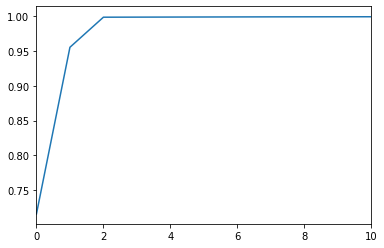

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimension of data
pca = PCA(n_components= 659)
pca.fit_transform(x_train)
np.set_printoptions(suppress=True)
pca_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot a fig to find a proper number of components 
plt.plot(pca_variance)
plt.xlim(0,10)

Use the plot to decide the number of components to keep, choose a number that explains atleast 95% of variance in the dataset. Here we choose 3, Then fit and transform our pca on training set using the number 3.

In [ ]:
# Transform the data based on the number of components founded
pca = PCA(n_components=3)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

### Linear Regression after PCA

In [ ]:
# Train linear regression based on the data after using PCA
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
mse_base = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_base)
print("RMSE: %f"%(rmse))

RMSE: 0.839084


We manage to get a 0.839 rmse, which is much smaller than the result before applying PCA. This result is ideal and meaning that our model is reliable.

### Random Forest


Aside from Linear Regression, we also train Random Forest Model to see its performance.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Here we use grid search and train a random forest model on the transformed train dataset. We use `GridSearchCV` to tune the max_depth hyperparameter.

In [ ]:
# Build a random forest model and use grid search to tune hyper parameter
parameters = {'max_depth': [50, 100, 200, 300, 400, 500, 1000], 'n_estimators': [100]}
regr = RandomForestRegressor()
clf = GridSearchCV(regr, parameters, verbose=2)
clf.fit(x_train, y_train)


In [ ]:
best_max_depth = clf.best_params_['max_depth']

In [ ]:
# Fit RF model with hyperparameter found
regr1 = RandomForestRegressor(max_depth= best_max_depth, n_estimators=100)
regr1.fit(x_train, y_train)
y_pred = regr1.predict(x_test)
rsme = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f"%(rmse))

RMSE: 0.839084


We also get a 0.839 rmse, which is much smaller than the result before applying PCA. So this result is ideal and meaning that our model is reliable.

## Linear regression on members

Then we do the simple linear regression on `members`, which stands for the number of audience of an anime. Linear regression should be an ideal model on predicting members of an anime given its features.

Drop some useless coulumn, like `title`. `title_japanese` and `anime_id`. Also, `score`,`rank`,`scored_by`,`popularity`.`favorites` are all criteria to define the quality of an anime, so when have to drop all of them because normally when we predict the number of audience of an anime, we wouldn't know its rank and score before the anime airing.

In [ ]:
anime_members_df = anime_df.drop(columns=['Unnamed: 0','title','score','scored_by','rank','popularity','favorites','title_japanese','anime_id'])

Then we apply One-hot encoding for `type`,`source`,`rating`, `studio` and `genre`. Convert them to columns with 1 and 0 representing if current entry has such feature.

In [ ]:
anime_members_df['rating'] = anime_members_df['rating'].astype('category')
anime_members_df['type'] = anime_members_df['type'].astype('category')
anime_members_df['source'] = anime_members_df['source'].astype('category')
anime_members_df['studio'] = anime_members_df['studio'].astype('category')
anime_members_df['genre'] = anime_members_df['genre'].astype('category')

In [ ]:
one_hot1 = pd.get_dummies(anime_members_df['rating'],prefix='rating')
anime_members_df = pd.concat([anime_members_df, one_hot1], axis= 1)

one_hot2 = pd.get_dummies(anime_members_df['studio'],prefix='studio')
anime_members_df = pd.concat([anime_members_df, one_hot2], axis= 1)

one_hot3 = pd.get_dummies(anime_members_df['genre'],prefix='genre')
anime_members_df = pd.concat([anime_members_df, one_hot3], axis= 1)

one_hot4 = pd.get_dummies(anime_members_df['type'],prefix='type')
anime_members_df = pd.concat([anime_members_df, one_hot4], axis= 1)

one_hot5 = pd.get_dummies(anime_members_df['source'],prefix='source')
anime_members_df = pd.concat([anime_members_df, one_hot5], axis= 1)

Remember to drop `type`,`source`,`rating`, `studio` and `genre` after One-Hot Encoding.

In [ ]:
anime_members_df = anime_members_df.drop(columns=['rating','type','source','studio','genre'])

In [ ]:
anime_members_df.columns = anime_members_df.columns.str.replace(".", " ")

### Split train test dataset

In order to do Linear Regression, we rename the `member` column to `label`, and extract two dataframe of `feature` and `label`. 

In [ ]:
anime_members_df.rename(columns={'members':'label'}, inplace = True)

# scale on label
anime_members_df['label'] =np.log(anime_members_df['label'])
anime_members_df

,episodes,label,start_year,duration_min,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,rating_Rx - Hentai,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A C G T,studio_ AIC,studio_ AIC A S T A,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Annapuru,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,studio_ Asread,studio_ Aubec,studio_ Azeta Pictures,studio_ Bandai Namco Pictures,studio_ Bandai Visual,studio_ BeSTACK,studio_ Bee Media,...,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,genre_Vampire,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Unknown,source_Visual novel,source_Web manga
0,12,12.556314,2012,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,26,12.225890,2007,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,51,11.158063,2008,24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,38,11.443704,2002,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,25,12.115956,2012,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,1,4.204693,2008,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8310,1,4.234107,2012,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8311,1,4.248495,2002,51,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8312,1,3.688879,2017,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
label = anime_members_df.iloc[:,1]
features = anime_members_df.drop(columns=['label']).iloc[:,:]

We convert the dataframe `feature` and `label` to arrays. And then use split to get training data and test data. Here we choose the split ratio to be 80-20, meaning 80% for training and rest for testing.

In [ ]:
from sklearn.model_selection import train_test_split

x= features.to_numpy()
y = label.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 

### Base Linear Regression

We run basic linear regression first and evaluate its performace by Rooted Mean Squared Error.

In [ ]:
# Build a basic linear regression model without dimension reduction
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
mse_base = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_base)
print("RMSE: %f"%(rmse))

RMSE: 219549359.522060


We get a pretty large number as Rooted Mean Squared Error, which is definitely not ideal. So we begin to apply dimension reduction to make it a better model.

### Apply PCA

Use Principal component analysis to reduce number of dimensions of the dataset, as a first step fit a pca model on our train set and then plot the explained_variance_ratio against the number of components to decide the number of components we should keep.

(0.0, 10.0)

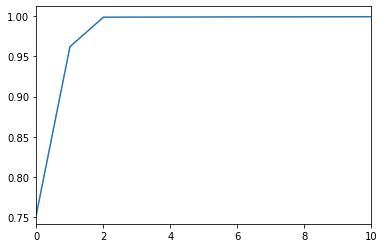

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimension of data
pca = PCA(n_components= 659)
pca.fit_transform(x_train)
np.set_printoptions(suppress=True)
pca_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot a fig to find a proper number of components 
plt.plot(pca_variance)
plt.xlim(0,10)

Use the plot to decide the number of components to keep, choose a number that explains atleast 95% of variance in the dataset. Here we choose 3, Then fit and transform our pca on training set using the number 3.

In [ ]:
# Transform the data based on the number of components founded
pca = PCA(n_components=3)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

### Linear Regression after PCA

In [ ]:
# Train linear regression based on the data after using PCA
lr = LinearRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)
mse_base = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse_base)
print("RMSE: %f"%(rmse))

RMSE: 2.042883


We manage to get a 2.043 rmse, which is much smaller than the result before applying PCA. This result is ideal and meaning that our model is reliable.

### Random Forest


Aside from Linear Regression, we also train Random Forest Model to see its performance.

Here we use grid search and train a random forest model on the transformed train dataset. We use `GridSearchCV` to tune the max_depth hyperparameter.

In [ ]:
# Build a random forest model and use grid search to tune hyper parameter
parameters = {'max_depth': [50, 100, 200, 300, 400, 500, 1000], 'n_estimators': [100]}
regr = RandomForestRegressor()
clf = GridSearchCV(regr, parameters, verbose=2)
clf.fit(x_train, y_train)
clf.get_params()

In [ ]:
best_max_depth = clf.best_params_['max_depth']

In [ ]:
# Fit RF model with hyperparameter found
regr1 = RandomForestRegressor(max_depth=best_max_depth, n_estimators=100)
regr1.fit(x_train, y_train)
y_pred = regr1.predict(x_test)
rsme = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f"%(rmse))

RMSE: 2.042883


We also get a 2.043 rmse, which is much smaller than the result before applying PCA. So this result is ideal and meaning that our model is reliable.

# Modeling: Predict leading gender of a given anime

## Logistic learning on leading gender

The leading gender here is defined as the majority gender of audience of each anime. We want to build a classifier on leading edge to allow our model to predict which gender will an anime would be polupar in. This is practical for some company for preparing strategy for boradcasting and attention.

To get the leading gender of each animate, we need the full version of user and anime list `User_Anime_Full_r.csv`, which contains over 30,000,000 entries. So we need to read it and do some strategy to avoid RAM overflow.

In [ ]:
user_full_df = pd.read_csv('User_Anime_Full_r.csv')
user_full_df.drop(columns = ['Unnamed: 0','Unnamed: 0.1'], inplace=True)

Take a look at the shape of current data.

In [ ]:
user_full_df.shape

(32525469, 14)

Then we need to counter the number of male and female audience for each anime. However, since 30,000,000 is too large we cannot use One-Hot encoding to convert `gender` to `male` and `female`, becuse the `.concat()` will break the program. Here we apply a method on `gender` to replace each `"male"` as 1 and each `"female"` as -1, then we do groupby one `anime_id` and use `.count()` as aggregation method. As a result, if `gender` is positive then male is the leading edge, esle female is.

In [ ]:
user_full_df['gender'] = user_full_df['gender'].apply(lambda x: 1 if x == 'Male' else -1)
temp_df = user_full_df.groupby('anime_id').sum()

With just `temp_df` is not enough, we also need other information we have dropped in `AnimeList.ipynb`, so we read the `Anime_cleaned.csv` back and merge it with `temp_df` to get the `anime_gender_df`.

In [ ]:
anime_df = pd.read_csv('Anime_cleaned.csv', header=[0])
anime_learning_df = anime_df.drop(columns=['Unnamed: 0'])
anime_gender_df = temp_df['gender'].reset_index().merge(anime_learning_df, on='anime_id')
anime_gender_df.drop(columns=['title', 'title_japanese'], inplace= True)

Now we can know if an anime is more polupar in male or female, in order to do logistic regression, we use 1 for male and 0 for female. So here we apply a lambda method to convert any positive number to 1 and any negative number to 0.

In [ ]:
anime_gender_df['gender'] = anime_gender_df['gender'].apply(lambda x: 1 if x>0 else 0)

## One-hot encoding

Then we apply One-hot encoding for `type`,`source`,`rating`, `studio` and `genre`. Convert them to columns with 1 and 0 representing if current entry has such feature.





In [ ]:
anime_gender_df['rating'] = anime_gender_df['rating'].astype('category')
anime_gender_df['type'] = anime_gender_df['type'].astype('category')
anime_gender_df['source'] = anime_gender_df['source'].astype('category')
anime_gender_df['studio'] = anime_gender_df['studio'].astype('category')
anime_gender_df['genre'] = anime_gender_df['genre'].astype('category')

In [ ]:
one_hot1 = pd.get_dummies(anime_gender_df['rating'],prefix='rating')
anime_gender_df = pd.concat([anime_gender_df, one_hot1], axis= 1)

one_hot2 = pd.get_dummies(anime_gender_df['studio'],prefix='studio')
anime_gender_df = pd.concat([anime_gender_df, one_hot2], axis= 1)

one_hot3 = pd.get_dummies(anime_gender_df['genre'],prefix='genre')
anime_gender_df = pd.concat([anime_gender_df, one_hot3], axis= 1)

one_hot4 = pd.get_dummies(anime_gender_df['type'],prefix='type')
anime_gender_df = pd.concat([anime_gender_df, one_hot4], axis= 1)

one_hot5 = pd.get_dummies(anime_gender_df['source'],prefix='source')
anime_gender_df = pd.concat([anime_gender_df, one_hot5], axis= 1)

Remember to drop `type`,`source`,`rating`, `studio` and `genre` after One-Hot Encoding.

In [ ]:
anime_gender_df = anime_gender_df.drop(columns=['anime_id','rating','type','source','studio','genre'])

In [ ]:
anime_gender_df.shape

(6589, 628)

## Split test data

In order to do Logistic Regression, we rename the `gender` column to `label`, and extract two dataframe of `feature` and `label`. 

In [ ]:
anime_gender_df.rename(columns={'gender':'label'}, inplace = True)
anime_gender_df

,label,episodes,score,scored_by,rank,popularity,members,favorites,start_year,duration_min,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,rating_Rx - Hentai,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A.C.G.T.,studio_ AIC,studio_ AIC A.S.T.A.,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Annapuru,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,studio_ Asread,...,genre_Military,genre_Music,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Visual novel,source_Web manga
0,1,26,8.81,365465,27.0,38,707773,39145,1998,24,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,1,8.41,111344,157.0,438,180246,706,2001,114,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,26,8.31,197843,234.0,138,373877,9795,1998,24,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,26,7.34,31908,2292.0,1104,75017,524,2002,25,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,52,7.04,4760,3400.0,3495,11276,13,2004,23,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,0,4,0.00,0,10119.0,14426,261,0,2017,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6585,0,4,0.00,0,10120.0,14427,364,0,2017,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6586,1,13,6.00,4,12485.0,14211,41,0,2017,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6587,1,12,7.53,17,11126.0,12779,126,0,2016,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
label = anime_gender_df.iloc[:,0]
features = anime_gender_df.drop(columns=['label']).iloc[:,:]

We convert the dataframe `feature` and `label` to arrays. And then use split to get training data and test data. Here we choose the split ratio to be 80-20, meaning 80% for training and rest for testing.

In [ ]:
from sklearn.model_selection import train_test_split

x= features.to_numpy()
y = label.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0) 

## Base Logistic Regression

We run basic Logistic Regression first and evaluate its performace by:

Accuracy: Describe the accuracy of prediction.

Precision: Low precision indicates a high number of false positives.

Recall: Low recall indicates a high number of false negatives.

F1 Score: the weighted average of precision and recall.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

clf = LogisticRegression(max_iter=10000)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)

accuracy = accuracy_score(prediction,y_test)
recall = recall_score(prediction,y_test)
f1 = f1_score(prediction,y_test)
precise = precision_score(prediction,y_test)

print("LR Accuracy: %.1f%%"% (accuracy*100))
print("LR Precision: %.1f%%"% (precise*100))
print("LR Recall: %.1f%%"% (recall*100))
print("LR f1 score: %.1f%%"% (f1*100))


LR Accuracy: 89.5%
LR Precision: 100.0%
LR Recall: 89.5%
LR f1 score: 94.5%


The result seems pretty good, but notice that for classification, we cannot just consider these scores. So here we draw the confusion matrix to measure the accuracy. The left top is True Negative (TN), the left bottom part is Flase Negative (FN), the right top part is False Positive (FP) and the right bottom part is True Positive(TP).



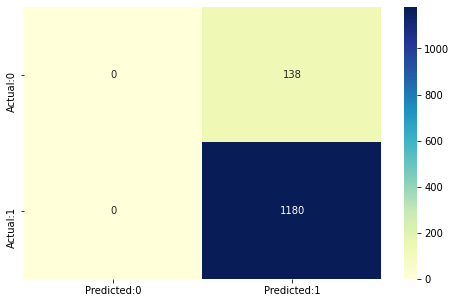

In [ ]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

From the confusion matrix we can see that this model makes almost all prediction result is 1, i.e. male is the leading gender for all animates. So how can we have such as high score? That is because the training data has greate imballance. Let see the bar plot of male and female as leading gender in 6000+ animes.

[Text(0, 0.5, 'gender count'), Text(0.5, 0, 'gender')]

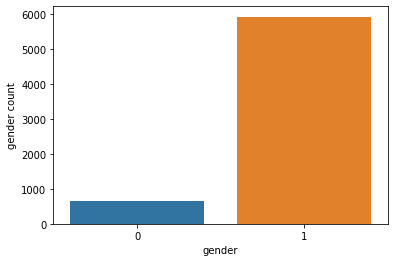

In [ ]:
gender_count = anime_gender_df.groupby('label').count().reset_index()

ax = sb.barplot(x='label',y='episodes', data=gender_count) 
ax.set(xlabel = 'gender',ylabel= 'gender count')

That is reason for the prediction, the training data is pretty imbalance and the classifier do misleadingly. How to handle this? We must do resampling.

## OverSampling

From the bar plot we can see the number of leading gender is pretty imbalance.

So we try oversampling and do Logistic regression again. 

Here we try random oversampling first, but the accuracy is not ideal. so implement SMOTE to do oversampling.

That is, SMOTE repeatly sample from the smaller class(here is class 0).

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='not majority')
x_ros, y_ros = sm.fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Since SMOTE change the data size of training data, so we draw learning curve to evaluate whether our training samples is proper.

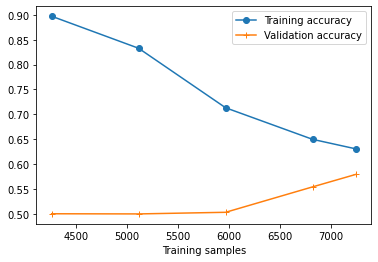

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
                estimator=clf, X=x_ros,
                 y=y_ros,
                 train_sizes=[0.5, 0.6, 0.7, 0.8, 0.85],
                 cv=10)
  
plt.plot(train_sizes,np.mean(train_scores, axis=1), marker='o', label='Training accuracy')
plt.plot(train_sizes,np.mean(test_scores, axis=1), marker='+', label='Validation accuracy')
plt.xlabel('Training samples')
plt.legend()

Then we apply Logistic Regression again to see the model's performance.

In [ ]:
clf = LogisticRegression(max_iter=10000)
clf.fit(x_ros,y_ros)
prediction = clf.predict(x_test)

accuracy = accuracy_score(prediction,y_test)
recall = recall_score(prediction,y_test)
f1 = f1_score(prediction,y_test)
precise = precision_score(prediction,y_test)

print("LR Accuracy: %.1f%%"% (accuracy*100))
print("LR Precision: %.1f%%"% (precise*100))
print("LR Recall: %.1f%%"% (recall*100))
print("LR f1 score: %.1f%%"% (f1*100))

LR Accuracy: 55.8%
LR Precision: 55.6%
LR Recall: 91.7%
LR f1 score: 69.2%


The scores are dramatically decreased, that is because oversampling will definitely have many duplicate training data and they may misleading. So we shall take a look at the confusion matrix.

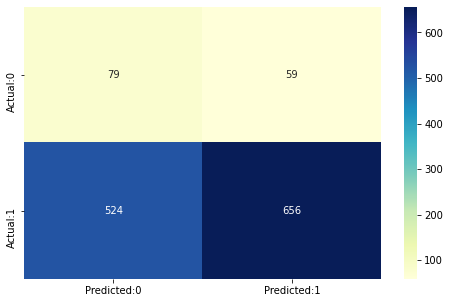

In [ ]:


confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
x_train = x_ros
y_train = y_ros

The confusion matrix shows that now we do not have a misleading model, however, the accuracy and other scores are not ideal because there are too much False Negative, we need handle them.

## Improved Logistic Regression with PCA

Use Principal component analysis to reduce number of dimensions of the dataset, as a first step fit a pca model on our train set and then plot the explained_variance_ratio against the number of components to decide the number of components we should keep.

(0.0, 10.0)

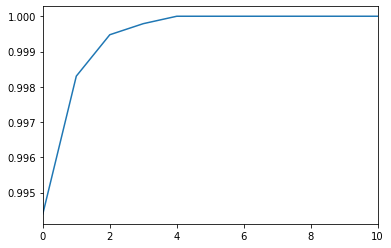

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimension of data
pca = PCA(n_components= 627)
pca.fit(x_train)
np.set_printoptions(suppress=True)
pca_variance = np.cumsum(pca.explained_variance_ratio_)
# Plot a fig to find a proper number of components 
plt.plot(pca_variance)
plt.xlim(0,10)

Use the plot to decide the number of components to keep, choose a number that explains atleast 95% of variance in the dataset. Here we choose 5, Then fit and transform our pca on training set using the number 5.

In [ ]:
# Transform the data based on the number of components founded
pca = PCA(n_components=5)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=10000, class_weight='balanced')
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)

accuracy = accuracy_score(prediction,y_test)
recall = recall_score(prediction,y_test)
f1 = f1_score(prediction,y_test)
precise = precision_score(prediction,y_test)

print("LR Accuracy: %.1f%%"% (accuracy*100))
print("LR Precision: %.1f%%"% (precise*100))
print("LR Recall: %.1f%%"% (recall*100))
print("LR f1 score: %.1f%%"% (f1*100))


LR Accuracy: 48.1%
LR Precision: 46.4%
LR Recall: 91.3%
LR f1 score: 61.6%


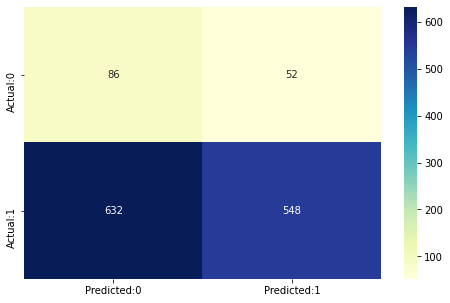

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

Unfortunately, the accuracy and other scores are still not ideal, and with confusion matrix we can see that PCA do increase True Negative a little bit, but the False Negative is still tremendous and even increase. We still need further tuning.

## Random forest 

Aside from Linear Regression, we also train Random Forest Model to see its performance, here we use the `x_train` and `y_train` after apply PCA.
Here we use grid search and train a random forest model on the transformed train dataset. We use `GridSearchCV` to tune the max_depth hyperparameter.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [10,20,30,40,50,60,70,80,90,200,500], 'n_estimators': [100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose=2)
clf.fit(x_train, y_train)
clf.get_params()

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... max_depth=10, n_estimators=100, total=   1.3s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=100, total=   1.2s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.2s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.2s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.3s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ................... max_depth=20, n_estimators=100, total=   1.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ................... max_depth=20, n_estimators=100, total=   1.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ................... max_depth=20, n_estimators=100, total=   1.7s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.6min finished


{'cv': None,
 'error_score': nan,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min

In [ ]:
best_max_depth = clf.best_params_['max_depth']


Run Random Forest Model to see the performance and scores.

In [ ]:
rfr = RandomForestClassifier(n_estimators= 100, max_depth= best_max_depth )
rfr.fit(x_train, y_train)
prediction = rfr.predict(x_test)

accuracy = accuracy_score(prediction,y_test)
recall = recall_score(prediction,y_test)
f1 = f1_score(prediction,y_test)
precise = precision_score(prediction,y_test)

print("LR Accuracy: %.1f%%"% (accuracy*100))
print("LR Precision: %.1f%%"% (precise*100))
print("LR Recall: %.1f%%"% (recall*100))
print("LR f1 score: %.1f%%"% (f1*100))

LR Accuracy: 80.0%
LR Precision: 84.7%
LR Recall: 92.3%
LR f1 score: 88.3%


We manage to get a 80% accuracy, 84.7% precision, 92.3% recall score and 88.3% f1 score! The result is ideal and promising, with such model, predicting leading genders for animates will be reliable accurate.

Finally we draw the confusion matrix to check it.

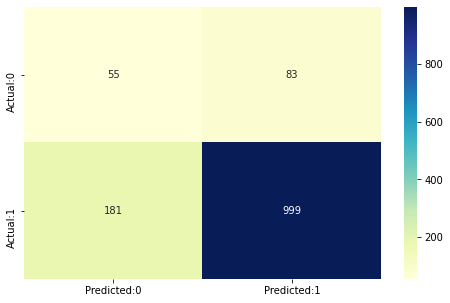

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

From the confusion matrix we can see, the Flase Negative get a great decrease, and the True negative does not fall too much, the false positive is also acceptable, meaning that we do get a promising model.

# Modeling: Predict whether a user like a given anime

This section is going to build models that take user features and anime features as input, predict whether user like certain anime or not as output (1 for like, 0 for non-like)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



## One-hot encoding

In the data, there are several features that are `text categorical labels`, e.g. `genre`, `studio`, `gender`. In order to do machine learning, these features need to be transfered to numeric values. Here, one-hot coding is used.

In [5]:
# Load data
Full_data = pd.read_csv('user_anime_full_100k.csv')

The goal of this part is to predict users like or dislike a given anime. This problem can be modeled as a `binary classification problem`. Define if a user give one anime a score higher than 7, he/she likes it (label as 1), else label as 0. Add this 'like' column to Full_data

In [6]:
# Define a function return 1 for like if 'my_score' >= 7
def like_transfer(user_row):
  if user_row['my_score'] >= 7:
    return 1;
  else:
    return 0; 
Full_data['like'] = Full_data.apply(lambda x: like_transfer(x), axis=1)
# Drop columns that are not going to be used
Full_data_bu = Full_data.drop(columns=['Unnamed: 0', 'username',  'my_score',  'start_year'])
Full_data_bu

,anime_id,user_id,gender,user_age,type,source,episodes,rating,score,scored_by,rank,popularity,members,favorites,studio,genre,duration_min,like
0,6987,1068179,Male,30,OVA,Manga,1,R+ - Mild Nudity,6.23,40251,6637.0,1184,69277,192,Hoods Entertainment,Ecchi,21,0
1,6987,172055,Female,27,OVA,Manga,1,R+ - Mild Nudity,6.23,40251,6637.0,1184,69277,192,Hoods Entertainment,Ecchi,21,0
2,6987,1407145,Male,23,OVA,Manga,1,R+ - Mild Nudity,6.23,40251,6637.0,1184,69277,192,Hoods Entertainment,Ecchi,21,0
3,6987,3110839,Male,29,OVA,Manga,1,R+ - Mild Nudity,6.23,40251,6637.0,1184,69277,192,Hoods Entertainment,Ecchi,21,1
4,6987,4849868,Male,48,OVA,Manga,1,R+ - Mild Nudity,6.23,40251,6637.0,1184,69277,192,Hoods Entertainment,Ecchi,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104189,10924,363205,Male,26,OVA,Other,2,R+ - Mild Nudity,6.48,3907,5692.0,3555,10862,11,Arms,Action,21,0
104190,2929,5978837,Female,29,TV,Manga,14,R+ - Mild Nudity,7.46,1207,1779.0,5711,3368,8,Studio Hibari,Adventure,25,0
104191,3546,4909435,Male,23,Special,Manga,1,PG-13 - Teens 13 or older,6.75,94,4533.0,9609,479,4,Tatsunoko Production,Comedy,24,0
104192,1981,1087343,Female,20,OVA,Original,2,PG-13 - Teens 13 or older,6.47,1560,5743.0,5272,4089,3,Ajia-Do,Mystery,30,0


In [7]:
# One hot encoding gender, rating, studio, genre, type, source, and drop original columns
Full_data_bu['gender'].astype('category')
Full_data_bu['rating'].astype('category')
Full_data_bu['studio'].astype('category')
Full_data_bu['genre'].astype('category')
Full_data_bu['type'].astype('category')
Full_data_bu['source'].astype('category')
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['gender'],prefix='gender')], axis=1)
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['rating'],prefix='rating')], axis=1)
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['studio'],prefix='studio')], axis=1)
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['genre'],prefix='genre')], axis=1)
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['type'],prefix='type')], axis=1)
Full_data_bu = pd.concat([Full_data_bu, pd.get_dummies(Full_data_bu['source'],prefix='source')], axis=1)
Full_data_bu.drop(columns=['anime_id', 'user_id', 'gender', 'rating', 'studio', 'genre', 'type', 'source'], inplace=True)
# Full_data_bu.drop(columns=['anime_id', 'user_id', 'gender', 'rating', 'genre', 'type', 'source', 'duration_min'], inplace=True)

In [ ]:
Full_data_bu

,user_age,episodes,score,scored_by,rank,popularity,members,favorites,duration_min,like,gender_Female,gender_Male,gender_Non-Binary,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A.C.G.T.,studio_ AIC,studio_ AIC A.S.T.A.,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,...,genre_Military,genre_Music,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Visual novel,source_Web manga
0,30,1,6.23,40251,6637.0,1184,69277,192,21,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,27,1,6.23,40251,6637.0,1184,69277,192,21,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,23,1,6.23,40251,6637.0,1184,69277,192,21,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,29,1,6.23,40251,6637.0,1184,69277,192,21,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,48,1,6.23,40251,6637.0,1184,69277,192,21,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104189,26,2,6.48,3907,5692.0,3555,10862,11,21,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
104190,29,14,7.46,1207,1779.0,5711,3368,8,25,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
104191,23,1,6.75,94,4533.0,9609,479,4,24,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
104192,20,2,6.47,1560,5743.0,5272,4089,3,30,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Extract correlation matrix from data to catch the relationships between features

In [ ]:
corr_matrix = Full_data_bu.corr()

In [ ]:
def corr(x):
  if abs(x) > 0.5:
    return 1
  else:
    return 0
corr_matrix.applymap(lambda x: corr(x)).apply(lambda x: x.cumsum())

,user_age,episodes,score,scored_by,rank,popularity,members,favorites,duration_min,like,gender_Female,gender_Male,gender_Non-Binary,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A.C.G.T.,studio_ AIC,studio_ AIC A.S.T.A.,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,...,genre_Military,genre_Music,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Visual novel,source_Web manga
user_age,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
episodes,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
score,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
scored_by,1,1,1,1,1,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
rank,1,1,2,1,2,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
source_Other,1,1,4,4,3,5,5,3,3,1,2,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,2,1,1,1,3,1,1,1,1,1,1,1,2,1,1,1,0,0,0,0
source_Picture book,1,1,4,4,3,5,5,3,3,1,2,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,2,1,1,1,3,1,1,1,1,1,1,1,2,1,1,1,1,0,0,0
source_Radio,1,1,4,4,3,5,5,3,3,1,2,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,2,1,1,1,3,1,1,1,1,1,1,1,2,1,1,1,1,1,0,0
source_Visual novel,1,1,4,4,3,5,5,3,3,1,2,2,1,1,1,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,3,2,1,1,1,3,1,1,1,1,1,1,1,2,1,1,1,1,1,1,0


In [ ]:
corr_matrix

,user_age,episodes,score,scored_by,rank,popularity,members,favorites,duration_min,like,gender_Female,gender_Male,gender_Non-Binary,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,studio_ 10Gauge,studio_ 3xCube,studio_ 81 Produce,studio_ 8bit,studio_ A-1 Pictures,studio_ A-Real,studio_ A.C.G.T.,studio_ AIC,studio_ AIC A.S.T.A.,studio_ APPP,studio_ AXsiZ,studio_ Ajia-Do,studio_ Amber Film Works,studio_ Amuse,studio_ Animate Film,studio_ Animation Do,studio_ Arms,studio_ Artland,studio_ Artmic,studio_ Asahi Production,studio_ Ascension,...,genre_Military,genre_Music,genre_Mystery,genre_Parody,genre_Police,genre_Psychological,genre_Romance,genre_Samurai,genre_School,genre_Sci-Fi,genre_Seinen,genre_Shoujo,genre_Shounen,genre_Slice of Life,genre_Space,genre_Sports,genre_Super Power,genre_Supernatural,genre_Thriller,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,source_4-koma manga,source_Book,source_Card game,source_Digital manga,source_Game,source_Light novel,source_Manga,source_Music,source_Novel,source_Original,source_Other,source_Picture book,source_Radio,source_Visual novel,source_Web manga
user_age,1.000000,0.003720,-0.058308,-0.091789,0.053136,0.129898,-0.099823,-0.045411,0.030138,0.058501,-0.057617,0.061871,-0.027798,0.014982,0.002066,-0.002878,-0.009897,-0.011166,0.023090,-0.004185,-0.006435,0.007671,0.001820,-0.012935,-0.005317,0.000637,0.000537,0.003992,0.003001,-0.006375,0.008098,0.008112,0.004232,0.012250,-0.010702,0.003118,0.002657,0.006231,0.000326,-0.009063,...,0.022319,-0.010852,-0.014222,0.004131,-0.001771,-0.003624,-0.008065,0.011727,0.000276,0.006192,0.005580,0.003473,-0.001358,-0.039053,0.004460,-0.014901,-0.007906,-0.005830,-0.008018,0.028697,0.004414,-0.012917,0.044911,0.000757,-0.045914,-0.011903,0.002042,-0.005912,-0.010003,0.000422,-0.051351,0.011753,-0.015052,-0.002845,0.046377,0.012037,0.007233,-0.001915,0.006733,-0.036496
episodes,0.003720,1.000000,0.145260,0.207035,-0.136468,-0.117367,0.242306,0.293596,-0.154453,0.025678,0.016818,-0.016495,-0.001336,-0.007993,-0.007080,0.069425,0.075689,-0.063747,-0.066303,-0.001406,-0.002575,-0.001331,-0.002694,0.103509,-0.001666,-0.002429,0.002874,0.000469,-0.001708,-0.004318,-0.002877,-0.002124,-0.001666,-0.005565,-0.005869,-0.002737,-0.002049,-0.006732,-0.004881,-0.009219,...,0.001769,-0.005129,-0.014758,-0.006243,-0.006127,-0.009296,-0.023488,-0.006442,-0.006892,-0.033964,-0.003674,-0.004217,0.004585,-0.030836,-0.003452,0.003329,-0.007168,-0.021149,0.004105,-0.169763,-0.022112,-0.019251,-0.115793,-0.105699,0.258466,-0.029225,0.003560,-0.008474,-0.005021,0.002712,-0.080910,0.168346,-0.019408,-0.029093,-0.069747,-0.021017,-0.001939,-0.001292,-0.038711,-0.018802
score,-0.058308,0.145260,1.000000,0.477843,-0.952083,-0.540856,0.508602,0.460624,0.204001,0.210197,0.012778,-0.013333,0.003822,-0.030270,-0.023847,-0.048035,0.044024,0.123527,-0.185158,-0.004474,-0.011675,-0.008660,-0.000431,0.022250,-0.012525,-0.031139,0.010045,-0.011471,-0.007291,-0.034819,-0.009119,-0.024991,-0.006089,-0.017307,0.004737,-0.007141,-0.006091,-0.020093,-0.016301,0.012144,...,0.013139,-0.005183,0.083269,-0.013503,-0.006681,0.018452,-0.037574,0.000978,-0.032319,-0.002910,-0.018939,-0.005230,-0.006311,0.065509,-0.008880,0.006936,-0.005409,0.018144,0.096445,0.122144,-0.024561,-0.095465,-0.102651,-0.103201,0.059901,-0.024612,-0.010261,-0.048673,-0.039081,-0.147393,-0.015252,0.115636,-0.008963,0.082042,0.001605,-0.092117,-0.013294,-0.011831,-0.095701,0.019452
scored_by,-0.091789,0.207035,0.477843,1.000000,-0.407358,-0.519833,0.988609,0.832702,-0.037480,0.167181,-0.006354,0.006131,0.001115,-0.081905,-0.017168,-0.042534,-0.062242,0.152200,-0.033885,-0.002426,-0.005413,-0.002426,-0.013304,0.053929,-0.006023,-0.009529,-0.008755,-0.009214,-0.007679,-0.012646,-0.006329,-0.008382,-0.006434,-0.011091,0.011423,-0.005858,-0.005720,-0.013475,-0.012383,-0.010304,...,-0.040768,-0.055660,0.092596,-0.0

Plot the heat map to show relationships between features (the figure can be zoomed if needed)

In [ ]:
fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.index,
                   y=corr_matrix.columns,
                   colorbar={'thicknessmode': 'pixels'},
                   colorscale='YlGnBu'))
fig.update_layout(height=1200, title='Correlation Map')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

From heatmap, there are some features that have strong correlations, i.e. the lower left corner of the map. So PCA is needed.

In [8]:
# Using a subset of data to reduce the time consumption and resource usage
Full_data_bu = Full_data_bu.sample(n=50000, random_state=42)

Split data into features set x and label set y. Also scaling the data using StandardScaler since the magnitude of features varies a lot. Then split data into train and test data set by fraction of `test_dataset : train_dataset = 1:4`

In [9]:
# Split data into train set and test set
x = Full_data_bu.drop(columns=['like']).to_numpy()
x = StandardScaler().fit_transform(x)
y = Full_data_bu['like'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 


## Simple Logistic Regression

Try modeling with simple LogisticRegression first. This model is used to get the approximate accuracy value and justify the size of training data based on learning curve.

In [ ]:
%%time
clf = LogisticRegression(max_iter=100000,random_state=42)
clf.fit(x_train,y_train)
prediction = clf.predict(x_test)

CPU times: user 5.18 s, sys: 544 ms, total: 5.73 s
Wall time: 2.95 s


Accuracy: 60.0%
Precision: 59.2%
Recall: 55.5%
              precision    recall  f1-score   support

           0       0.61      0.64      0.62      5169
           1       0.59      0.55      0.57      4831

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



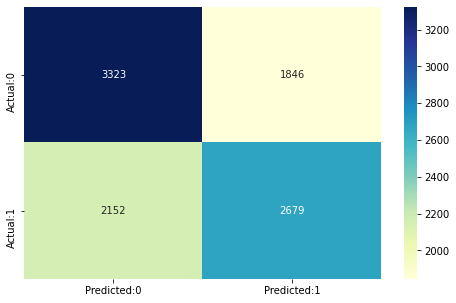

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, prediction)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, prediction)*100))
print(sklearn.metrics.classification_report(y_test, prediction))

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

From the figure and the statistics, the sample is balanced. There is no need to resample dataset.

Plotting learning curve for Logistic model

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
  learning_curve(estimator=clf, X=x_train,
                 y=y_train,
                 train_sizes=[0.05, 0.2, 0.4, 0.6, 0.8, 0.85],
                 cv=10)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_sizes,
    y=np.mean(train_scores, axis=1),
    name = 'Training accuracy', 
    connectgaps=True 
))
fig.add_trace(go.Scatter(
    x=train_sizes,
    y=np.mean(test_scores, axis=1),
    name='Validation accuracy',
))

fig.update_layout(width=800, title='Learning curve')
fig.update_xaxes(title='Training samples')
fig.update_yaxes(title='Accuracy')
fig.show()

From learning curve, it could be concluded that with this training dataset, the model is neither over-fitting nor under-fitting

## Logistic Regression with PCA

Since from heatmap, there could be correlations between some features, use PCA to address this issue and transform data to lower dimension form.

In [ ]:
pca = PCA()
pca.fit(x_train)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
df = pd.DataFrame(pc_vs_variance, columns=['explained_variance_ratio'])
fig = px.line(df, x=df.index, y="explained_variance_ratio")
fig.update_layout(width=800)
fig.update_xaxes(title='features')
fig.show()

From the figure above, when # of features = 400, explained_variance_ratio is about 0.91.

In [10]:
# Transform data into 400 components
pca = PCA(n_components=400)
pca.fit(x_train)
x_train_2 = pca.transform(x_train)
x_test_2 = pca.transform(x_test)

In [10]:
%%time
clf = LogisticRegression(max_iter=10000,random_state=42)
clf.fit(x_train_2,y_train)
prediction = clf.predict(x_test_2)

CPU times: user 13.7 s, sys: 1.56 s, total: 15.3 s
Wall time: 7.76 s


Accuracy: 59.6%
Precision: 58.7%
Recall: 56.2%


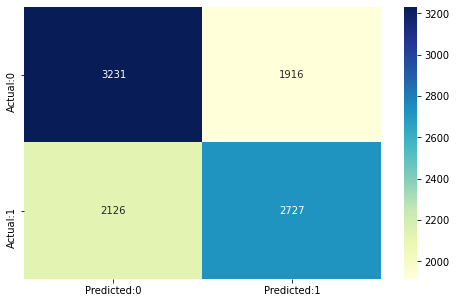

In [11]:
confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, prediction)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, prediction)*100))

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
  learning_curve(estimator=clf, X=x_train_2,
                 y=y_train,
                 train_sizes=[0.05, 0.2, 0.4, 0.6, 0.8, 0.85],
                 cv=10)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_sizes,
    y=np.mean(train_scores, axis=1),
    name = 'Training accuracy', 
    connectgaps=True 
))
fig.add_trace(go.Scatter(
    x=train_sizes,
    y=np.mean(test_scores, axis=1),
    name='Validation accuracy',
))

fig.update_layout(width=800, title='Learning curve')
fig.update_xaxes(title='Training samples')
fig.update_yaxes(title='Accuracy')
fig.show()

As can be seen here, once using PCA, accuracy, precision and recall are basically stay the same, with more time consuming. Learning curve shows that with this training set, logistic regression model is neither over-fitting or under-fitting. `The ultimate accuracy is about 0.61`.

## Random Forest

Random Forest is another model that is worth to try when modeling for a classification problem.

First of all, search for a better set of hyperparameters (max_depth, n_estimators) by `GridSearch`

In [ ]:
parameters = {'max_depth': [100, 200, 300], 'n_estimators': [150]}
rfcf = RandomForestClassifier()
clf = GridSearchCV(rfcf, parameters, verbose=2)
clf.fit(x_train_2, y_train)
clf.get_params()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=100, n_estimators=150 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=100, n_estimators=150, total= 1.0min
[CV] max_depth=100, n_estimators=150 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] .................. max_depth=100, n_estimators=150, total= 1.1min
[CV] max_depth=100, n_estimators=150 .................................
[CV] .................. max_depth=100, n_estimators=150, total= 1.0min
[CV] max_depth=100, n_estimators=150 .................................
[CV] .................. max_depth=100, n_estimators=150, total= 1.0min
[CV] max_depth=100, n_estimators=150 .................................
[CV] .................. max_depth=100, n_estimators=150, total= 1.0min
[CV] max_depth=200, n_estimators=150 .................................
[CV] .................. max_depth=200, n_estimators=150, total= 1.0min
[CV] max_depth=200, n_estimators=150 .................................
[CV] .................. max_depth=200, n_estimators=150, total= 1.1min
[CV] max_depth=200, n_estimators=150 .................................
[CV] .................. max_depth=200, n_estimators=150, total= 1.0min
[CV] max_depth=200, n_estimators=150 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 15.6min finished


{'cv': None,
 'error_score': nan,
 'estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min

In [ ]:
clf.best_params_

{'max_depth': 200, 'n_estimators': 150}

Use the hyperparameters found by GridSearch to build Random Forest model.
Train and test the model.

In [ ]:
%%time
rfcf1 = RandomForestClassifier(max_depth=200, n_estimators=150)
rfcf1.fit(x_train_2, y_train)
y_pred = rfcf1.predict(x_test_2)


CPU times: user 2min 52s, sys: 51.2 ms, total: 2min 52s
Wall time: 2min 52s


Accuracy: 56.0%
Precision: 54.6%
Recall: 53.2%


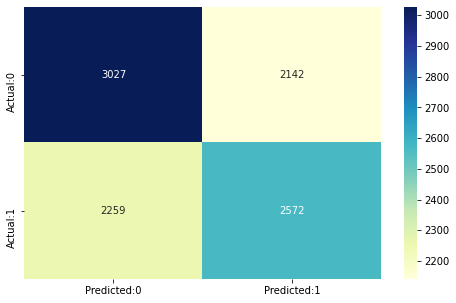

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
accuracy = sklearn.metrics.accuracy_score(y_pred,y_test)

print("Accuracy: %.1f%%"% (accuracy*100))
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, y_pred)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, y_pred)*100))

conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

It can be seen that the accuracy, precision and recall are lower than logistic regression model. Also, it needs more time to train.

## SVM

Suppor Vector Machine (SVM) is another userful model for classfication, its will have equivalent or better performance than Random Forest. 

SVM can use different kernels, e.g. rbf, linear. The result and performance could be different if different kernel functions are used.

### SVC with rbf kernel

RBF kernel is often used when the number of features is large. The number of features in the dataset is 400 which may be suitable for RBF kernel.

Precision: 59.0%
Recall: 53.8%
Accuracy: 59.6%


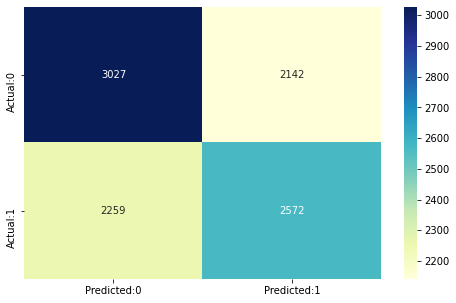

In [ ]:
clf = svm.SVC(cache_size=4000)
clf.fit(x_train_2, y_train)
prediction = clf.predict(x_test_2)
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, prediction)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, prediction)*100))
print("Accuracy: %.1f%%"% (clf.score(x_test_2, y_test)*100))
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### SVC with linear kernel

Linear kernel is another commonly used kernel. Although this kernel is suitable for low dimension, the model is worth to try.

Accuracy: 60.2%
Precision: 58.6%
Recall: 61.2%


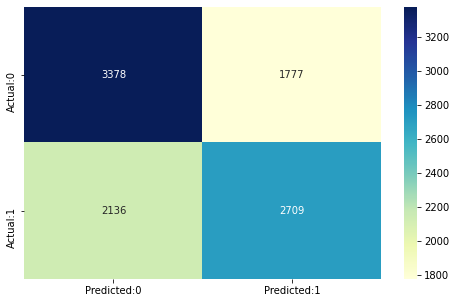

In [ ]:
clf = svm.SVC(kernel='linear', cache_size=6000)
clf.fit(x_train_2, y_train)
prediction = clf.predict(x_test_2)
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (clf.score(x_test_2, y_test)*100))
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, prediction)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, prediction)*100))
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

From the above results, both SVC-RBF(RBF kernel) and SVC-Linear(Linear kernel) have similar performance. But SVC-Linear has higher recall. From the SVC-Linear is more suitable for large dataset. This can be concluded from the result above

## Gradient Boosting

Gradient Boosting Classifier is a great ensemble model for binary or multiclass classification. It constructs an ensemble of weak classifiers. This ensemble method can have better performance than some more complex models

Accuracy: 59.9%
Precision: 58.6%
Recall: 54.3%


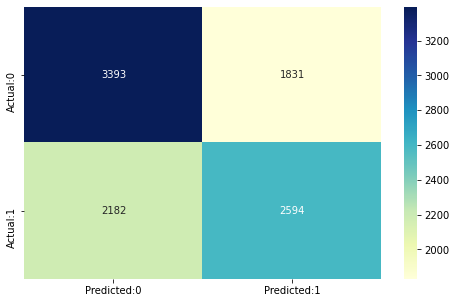

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
clf.fit(x_train_2, y_train)
prediction = clf.predict(x_test_2)
confmat = confusion_matrix(y_true=y_test, y_pred=prediction)
accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (clf.score(x_test_2, y_test)*100))
print("Precision: %.1f%%" %(sklearn.metrics.precision_score(y_test, prediction)*100))
print("Recall: %.1f%%" %(sklearn.metrics.recall_score(y_test, prediction)*100))
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

## Multi-layer Neural Network

Using multi-layer Neural Network is famous for deep learning these days, it can be used to learn regression and classification. A `three layers` neural network is built by mxnet to be trained and predict in this part.

In [ ]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [ ]:
import mxnet as mx
import mxnet.ndarray as F
from __future__ import print_function
from mxnet import gluon
from mxnet import nd
from mxnet.gluon import nn
from mxnet import autograd as ag

Split training data with fraction 0.125. This subset of training data are set to be used as cross validation data, set dropout to avoid over-fitting 

In [ ]:
batch_size = 5000
# Split data into train, validation, test data
x_train_nn, x_val, y_train_nn, y_val = train_test_split(x_train, y_train, test_size=0.125) 
train_data = mx.io.NDArrayIter(x_train_nn, y_train_nn, batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(x_val, y_val, batch_size)
test_data = mx.io.NDArrayIter(x_test, y_test, batch_size)


# Build neural network
net = gluon.nn.Sequential()
with net.name_scope():
  net.add(nn.Flatten())
  net.add(nn.Dense(300, activation='relu'))
  net.add(nn.Dropout(0.2))
  net.add(nn.Dense(64))
  net.add(nn.Dropout(0.4))
  net.add(nn.Dense(2))
# Set current context
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
# Initialize net weights
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adagrad', {'learning_rate': 0.1})

metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

# Training
epochs = 30

train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in range(epochs):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    batch_count = 0
    for batch in train_data:
        total_train_loss = 0
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        trainer.step(batch.data[0].shape[0])
        curr_loss = nd.mean(loss).asscalar()
        total_train_loss += curr_loss
        batch_count += 1
    # Gets accuracy.
    name, acc = metric.get()
    # Reset evaluation metric.
    metric.reset()
    # Calculate average train loss for each epoch
    avg_train_loss = total_train_loss / batch_count
    train_acc.append(acc)
    train_loss.append(avg_train_loss)
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

    # Use Accuracy as the evaluation metric.
    metric = mx.metric.Accuracy()
    # Reset the validation data iterator.
    val_data.reset()
    # Loop over the validation data iterator.
    batch_count = 0
    for batch in val_data:
        total_val_loss = 0
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error.
                loss.backward()      
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Calculate val loss for each epoch
        curr_loss = nd.mean(loss).asscalar()
        total_val_loss += curr_loss
        batch_count += 1

    avg_val_loss = total_val_loss / batch_count
    name, acc = metric.get()
    val_loss.append(avg_val_loss)
    val_acc.append(acc)
    print('validation acc: %s=%f'%metric.get())
    

training acc at epoch 0: accuracy=0.531933
validation acc: accuracy=0.555067
training acc at epoch 1: accuracy=0.572167
validation acc: accuracy=0.581467
training acc at epoch 2: accuracy=0.588611
validation acc: accuracy=0.592667
training acc at epoch 3: accuracy=0.596956
validation acc: accuracy=0.595667
training acc at epoch 4: accuracy=0.600500
validation acc: accuracy=0.593133
training acc at epoch 5: accuracy=0.602778
validation acc: accuracy=0.604400
training acc at epoch 6: accuracy=0.607156
validation acc: accuracy=0.600600
training acc at epoch 7: accuracy=0.605756
validation acc: accuracy=0.602400
training acc at epoch 8: accuracy=0.606489
validation acc: accuracy=0.602533
training acc at epoch 9: accuracy=0.608122
validation acc: accuracy=0.608133
training acc at epoch 10: accuracy=0.609189
validation acc: accuracy=0.607200
training acc at epoch 11: accuracy=0.608233
validation acc: accuracy=0.598067
training acc at epoch 12: accuracy=0.608189
validation acc: accuracy=0.601

For machine learning problem, it is important to plot learning curves to see if there is over-fitting or under-fitting

In [ ]:
# Collect loss data during training
loss_df = pd.DataFrame(train_loss, columns=['train_loss'])
loss_df['val_loss'] = val_loss
loss_df['epoch'] = range(1,epochs +1 )
loss_df.set_index('epoch', inplace=True)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=loss_df.index,
    y=loss_df.train_loss,
    name = 'train_loss', 
    connectgaps=True
))
fig.add_trace(go.Scatter(
    x=loss_df.index,
    y=loss_df.val_loss,
    name='val_loss',
))

fig.update_layout(width=800, title='Train_loss and Val_loss')
fig.update_xaxes(title='epoch')
fig.update_yaxes(title='loss')
fig.show()

From validation curve, with the increasing of epoch, both train_loss and val_loss decrease. 

After 5 epoch, train_loss stay at similar value. 

After 15 epoch, val_loss stay at similar value.

There is no such a point that the gap between train_loss and val_loss becomes larger, so there is no over-fitting.

Then validation curve from accuracy aspect is created.

In [ ]:
# Collect accuracy data during trainging and validation
acc_df = pd.DataFrame(train_acc, columns=['train_acc'])
acc_df['val_acc'] = val_acc
acc_df['epoch'] = range(1,epochs +1 )
acc_df.set_index('epoch', inplace=True)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=acc_df.index,
    y=acc_df.train_acc,
    name = 'train_acc', 
    connectgaps=True 
))
fig.add_trace(go.Scatter(
    x=acc_df.index,
    y=acc_df.val_acc,
    name='val_acc',
))

fig.update_layout(width=800, title='Train_acc and Val_acc')
fig.update_xaxes(title='epoch')
fig.update_yaxes(title='Accuracy')
fig.show()

From this validation curve, the gap between train_acc and val_acc increases with the increase of epoch.

Before 10 epoch, train_acc and val_acc increase similarly.

After 10 epoch, the gap between train_acc and val_acc becomes obvious.

It is safe to use epoch 10 as actual epoch to train network

In [ ]:
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adagrad', {'learning_rate': 0.1})

metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

# Training
epochs = 10

train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in range(epochs):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    batch_count = 0
    for batch in train_data:
        total_train_loss = 0
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        trainer.step(batch.data[0].shape[0])
        curr_loss = nd.mean(loss).asscalar()
        total_train_loss += curr_loss
        batch_count += 1
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    # Calculate average train loss for each epoch
    avg_train_loss = total_train_loss / batch_count
    # Add accuracy and loss to list
    train_acc.append(acc)
    train_loss.append(avg_train_loss)
    

Feed into test data to get the performance (accuracy) of this trained network

In [ ]:
prediction=[]
actual_label=[]
for batch in test_data:
    total_train_loss = 0
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    with ag.record():
      for x, y in zip(data, label):
          z = net(x)
          outputs.append(z)

    metric.update(label, outputs)

name, acc = metric.get()
print("Accuracy: %.1f%%"%(acc*100))

Accuracy: 60.4%


## Model Comparison

Since several model are trained, it is needed to compare the performance of those models.

In [ ]:
accuracy = [0.600, 0.598, 0.560, 0.596, 0.602, 0.599]
precision = [0.592, 0.588, 0.546, 0.590, 0.586, 0.586]
recall = [0.555, 0.562, 0.532, 0.538, 0.612, 0.543]
cmp_df = pd.DataFrame(accuracy, index=['Simple LR', 'LR with PCA', 'Random Forest', 'SVC-RBF', 'SVC-Linear', 'GradientBoosting'], columns=['accuracy'])
cmp_df['precision'] = precision
cmp_df['recall'] = recall
cmp_df

,accuracy,precision,recall
Simple LR,0.600,0.592,0.555
LR with PCA,0.598,0.588,0.562
Random Forest,0.560,0.546,0.532
SVC-RBF,0.596,0.590,0.538
SVC-Linear,0.602,0.586,0.612
GradientBoosting,0.599,0.586,0.543


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=cmp_df.index,
    y=cmp_df.accuracy,
    opacity=0.9,
    name='Accuracy'
))
fig.add_trace(go.Bar(
    x=cmp_df.index,
    y=cmp_df.precision,
    opacity=0.9,
    name='Precision'
))
fig.add_trace(go.Bar(
    x=cmp_df.index,
    y=cmp_df.recall,
    opacity=0.9,
    name='Recall'
))

fig.update_layout(width=800)
fig.update_yaxes(range=(0.5, 0.65))
fig.show()

From the above, Random Forest have the poorest performance. This may because the parameters of it are not optimized enough.
SVC-RBF, SVC-Linear and GradientBoosting have better accuracy or prediction than LR and RF.

SVC-RBF, SVC-Linear and GradientBoosting have similar accuracy and precision. But SVC-Linear has the highest Recall. From this perspective, SVC-Linear is the best model. However, GradientBoosting uses less than half of the time SVC models needed to train. If cost is one of the most important considerations GrdientBoosting is the best choice.

Also, Neural Network is a good choice, since it has relatively high accuracy 60.4% and fastest training speed. But there are many parameters to be tuned and considered. By tuning parameters Neural network may have the best performance and fastsest speed at the same time. It has the biggest potentials.

The accuracy of ~60% is not a large absolute value. Since all the models are displaying similar performance, there could be some problems in dataset or feature engineering. Further work will involve improving data and parameters of models. 